In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datetime import datetime

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from trainer import Trainer

/Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <C69A961D-3985-36BA-99AC-E0EB4462554A> /Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Utility Functions

In [8]:
def get_device():
    """Get available device"""

    if torch.cuda.is_available():
        print("Using CUDA...")
        return torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print("Using MPS...")
        return torch.device("mps")
    else:
        print("Using CPU...")
        return torch.device("cpu")

def imshow(img):
    """Display CIFAR10 image"""
    
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
# setup device
device = get_device()

Using MPS...


### Load CIFAR-10 dataset

In [10]:
BATCH_SIZE = 4

# dataset loading from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import warnings
warnings.filterwarnings('always', message='', category=UserWarning, module='', lineno=0, append=True)

Input Tensor: torch.Size([3, 32, 32])
Label: 6


/Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <C69A961D-3985-36BA-99AC-E0EB4462554A> /Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlop

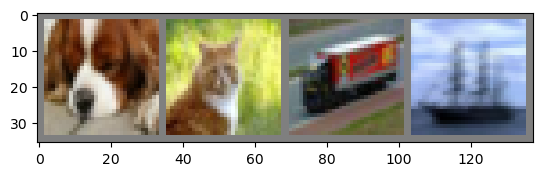

dog   cat   truck ship 


In [42]:
# get one sample
images, labels = trainset[0]

print(f"Input Tensor: {images.shape}")
print(f"Label: {labels}")

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

### Training Existing ResNet-18 Model
We will call PyTorch's existing implementation the baseline model

In [12]:
baseline_net = torchvision.models.resnet18(pretrained=True)
baseline_net

/Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/andy/miniconda3/envs/40.319/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# setup trainer class to fine-tune ResNet-18
baseline_trainer = Trainer(baseline_net, device=device)

### Training My PyTorch Implementation of ResNet-18

In [36]:
from resnet18 import ResNet18

resnet = ResNet18.from_pretrained("resnet18")
print("let's go, we didn't crash!")
resnet_trainer = Trainer(resnet, device=device)

loading weights from pytorch pretrained resnet18
let's go, we didn't crash!


# Acknowledgements

- [PyTorch CIFAR10 Training Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [A Detailed Introduction to ResNet and Its Implementation in PyTorch](https://medium.com/@freshtechyy/a-detailed-introduction-to-resnet-and-its-implementation-in-pytorch-744b13c8074a) by Huili Yu
- [Let's reproduce GPT-2 (124M)](https://www.youtube.com/watch?v=l8pRSuU81PU) by Andej Karpathy
- [Helpful conventions for PyTorch model building](https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict/blob/master/README.md) by FrancescoSaverioZuppichini  